# Introduction 

Dalam notebook ini, kita akan mengeksplorasi sentimen analysis pada beberapa dataset dengan pendekatan transfer learing LLM. Tujuan dari analisis ini adalah untuk mendapatkan wawasan yang lebih dalam dari dataset dan model LLM yang digunakan. 

## Tim Peneliti
Tim penelitian ini terdiri dari mahasiswa Teknik Informatik ITS:
- Muhammad Rifqi Ma'ruf
- Fadhl Akmal

## Dataset
Dataset yang digunakan antara lain:
- Pemilu
- BBM
- Penyakit


# Import Libraries

In [1]:
# Mengunduh lbraries yang dibutuhkan
%pip install transformers
%pip install Sastrawi
%pip install emoji

# Mengunduh / clone repository
!git clone https://github.com/rifqimaruf/indonlu.git

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Cloning into 'indonlu'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 500 (delta 115), reused 139 (delta 110), pack-reused 316 (from 1)
Receiving objects: 100% (500/500), 9.45 MiB | 23.72 MiB/s, done.
Resolving deltas: 100% (235/235), done.


In [2]:
# libraries untuk data processing
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from IPython.display import display, HTML
from collections import defaultdict

# Melakukan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

# Natural Language Processing Libraries
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import defaultdict
import emoji

# Melaukan Handling Imbalance Dataset
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import RandomOverSampler

# Deep Learning libraries untuk Model IndoBERT
import torch
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR

# Transformers libraries untuk IndoBert
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

# IndoNLU utilities untuk Sentiment Analysis
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

import time

# Download libraries tokenizer dan stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Menghapus folder yang sudah ada 
import shutil
# shutil.rmtree('/kaggle/working/indonlu')

# Data Loading

In [4]:
display(HTML("<h2> Membaca Data</h2>\n"))
# Membaca dataset Pemilu dan BBM
# pemilu_df = pd.read_csv("/kaggle/input/pemilu/pemilu_data_preprocessed.tsv", delimiter = '\t')
bbm_df = pd.read_csv("/kaggle/input/dataset-bu-ratih/bbm_data_preprocessed.tsv", delimiter = '\t')

# Menampilkan beberapa baris dari dataframe
# print("Pemilu DataFrame:")
# display(pemilu_df.head())

print("BBM DataFrame:")
display(bbm_df.head())

BBM DataFrame:


,text,sentiment
0,uang bukti dulu kalau ngetik hy gaes bagus mor...,neutral
1,kayang kaya talaga paikutin gong itong bbm ka...,neutral
2,bajingany mna om apa obral ikn apa apa bo...,negative
3,kamu bicara lahir pas jaman orde baru jadi ert...,negative
4,gaji besar bukan tunjang kerja baik pertamina...,negative


# Data Exploration

In [5]:
# 1. Menampilkan ringkasan informasi umum DataFrame 
# display(HTML("<h2> Ringkasan Informasi Data Pemilu</h2>\n"))
# pemilu_df.info(),
print("===================================================")
display(HTML("<h2> Ringkasan Informasi Data BBM</h2>"))
bbm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7022 entries, 0 to 7021
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       7022 non-null   object
 1   sentiment  7022 non-null   object
dtypes: object(2)
memory usage: 109.8+ KB


In [6]:
# 2. Donat Plot
# Fungsi Donat Plot
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [7]:
# # Argument plot untuk Pemilu
# sizes_pemilu = pemilu_df.sentiment.value_counts()
# labels_pemilu = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
# colors_pemilu = ['lightgreen', 'lightskyblue', 'lightcoral']
# explode_pemilu = (0, 0, 0)

# Argument plot untuk BBM
sizes_bbm = bbm_df.sentiment.value_counts()
labels_bbm = ['Tweet Netral', 'Tweet Negatif', 'Tweet Positif']
colors_bbm = ['lightgreen', 'lightskyblue', 'lightcoral']
explode_bbm = (0, 0, 0)

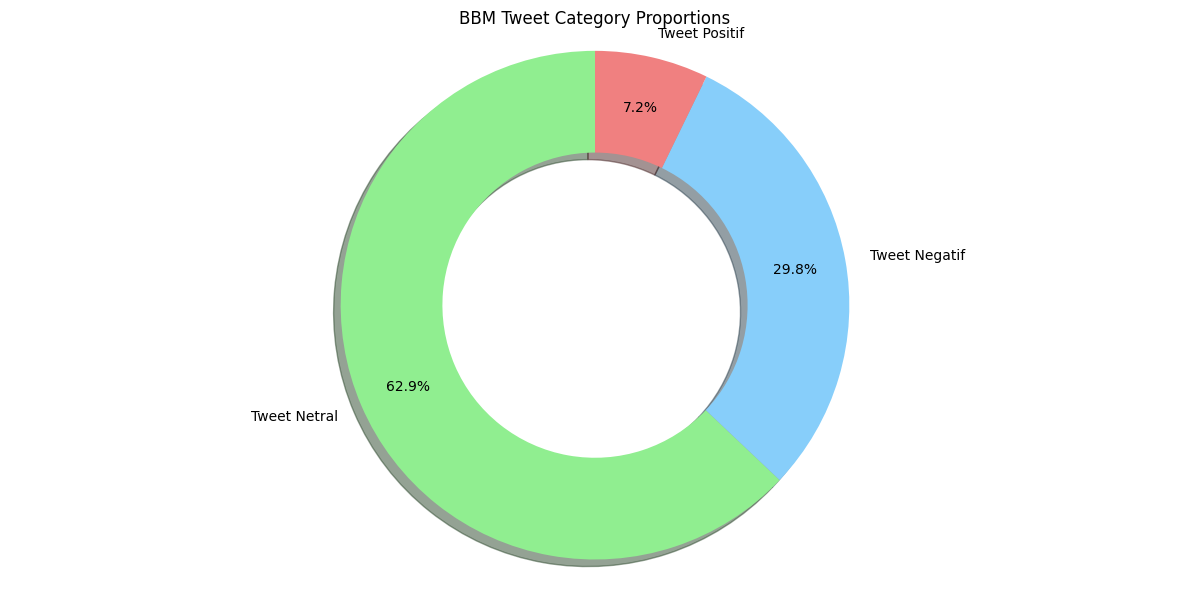

In [8]:
# Membuat Figure dan Axis untuk dua subplot
fig, ax2 = plt.subplots(1, 1, figsize=(12, 6))

# # Plot donat untuk Pemilu
# donut(sizes_pemilu, ax1, 90, labels_pemilu, colors=colors_pemilu, explode=explode_pemilu, shadow=True)
# ax1.set_title('Pemilu Tweet Category Proportions')

# Plot donat untuk BBM
donut(sizes_bbm, ax2, 90, labels_bbm, colors=colors_bbm, explode=explode_bbm, shadow=True)
ax2.set_title('BBM Tweet Category Proportions')

# Menampilkan plot
plt.tight_layout()
plt.show()
     

In [9]:
# 3. Mengecek WordFrequency dan Wordcloud
# Fungsi untuk membuat corpus dari kolom teks
def make_corpus(column):
    corpus_list = [word for text in column for word in text.split(' ')]
    corpus = ' '.join(corpus_list)
    return re.sub(' +', ' ', corpus)  # Mengganti spasi ganda dengan satu spasi

# Fungsi untuk menghitung frekuensi kata
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    df = pd.DataFrame(freqdist.most_common(top), columns=['word', 'freq'])
    return df

In [10]:
# Membuat corpus dan menghitung frekuensi untuk kedua DataFrame
# corpus_pemilu = make_corpus(pemilu_df['text'])
corpus_bbm = make_corpus(bbm_df['text'])

# corpus_freq_pemilu = word_freq(corpus_pemilu, top=20)
corpus_freq_bbm = word_freq(corpus_bbm, top=20)

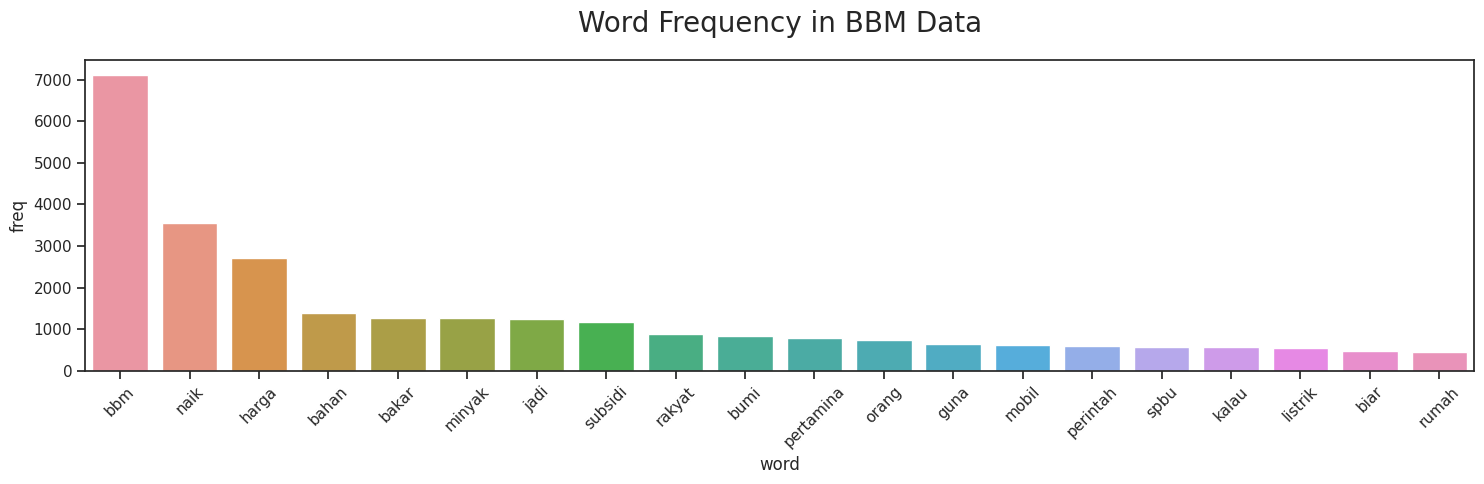

In [11]:
# Mengatur parameter visualisasi
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Membuat figure dengan dua subplot (dua axis)
fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))

# # Plot frekuensi kata untuk data Pemilu
# sns.barplot(x='word', y='freq', data=corpus_freq_pemilu, ax=ax1)
# ax1.set_title('Word Frequency in Pemilu Data')
# ax1.tick_params(axis='x', rotation=45)

# Plot frekuensi kata untuk data BBM
sns.barplot(x='word', y='freq', data=corpus_freq_bbm, ax=ax2)
ax2.set_title('Word Frequency in BBM Data')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

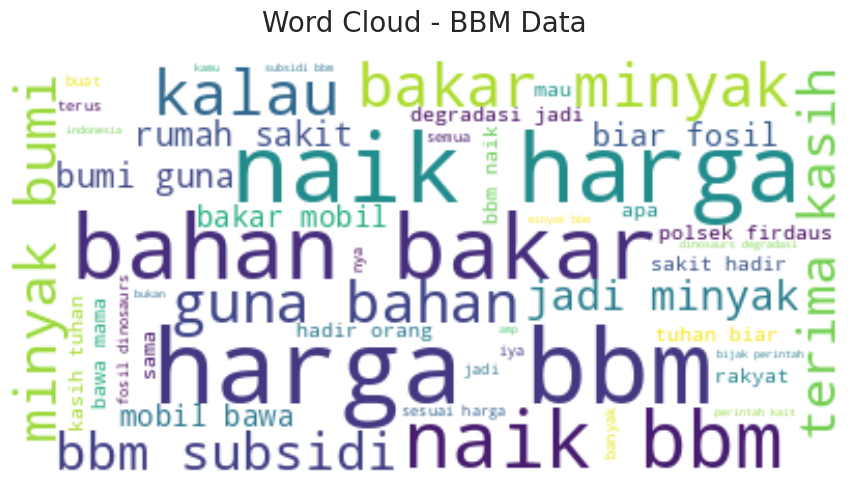

In [12]:
# Membuat WordCloud untuk kedua corpus
fig, ax2 = plt.subplots(1, 1, figsize=(15, 5))

# # WordCloud untuk corpus Pemilu
# wordcloud_pemilu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_pemilu)
# ax1.imshow(wordcloud_pemilu, interpolation="bilinear")
# ax1.axis("off")
# ax1.set_title('Word Cloud - Pemilu Data')

# WordCloud untuk corpus BBM
wordcloud_bbm = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_bbm)
ax2.imshow(wordcloud_bbm, interpolation="bilinear")
ax2.axis("off")
ax2.set_title('Word Cloud - BBM Data')

plt.tight_layout()
plt.show()

In [13]:
# 4. Mengecek duplikasi value
bbm_df.duplicated().sum()

671

In [14]:
bbm_df.drop_duplicates(inplace=True)

In [15]:
# 5. Menampilkan ukuran baris dan kolom DataFrame
bbm_df.shape

(6351, 2)

# Train and Modelling

In [16]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [17]:
# Fungsi untuk menyiapkan dataset dan label
def prepare_dataset_and_labels(dataset):
    all_labels = np.array([dataset[i][1] for i in range(len(dataset))])
    all_texts = [dataset[i][0] for i in range(len(dataset))]
    return all_texts, all_labels

# Fungsi untuk mengukur evaluasi matric
def compute_metrics(preds, labels):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)
    return precision, recall, f1, cm


In [18]:
# Function to plot the history for a given dataset
def plot_history(history, title):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_precision'], label='Train Precision')
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall and F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_recall'], label='Train Recall')
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.plot(epochs, history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.title('Recall and F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [19]:
class DocumentSentimentDataset(torch.utils.data.Dataset):
    LABEL2INDEX = {"neutral": 0, "positive": 1, "negative": 2}

    def __init__(self, dataset_path, tokenizer, lowercase=False):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.lowercase = lowercase

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t')
        df.columns = ['text', 'sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']
        if self.lowercase:
            text = text.lower()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            return_attention_mask=True,
            padding='max_length',
            max_length=512,
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(), sentiment


In [20]:
def save_model_weights(weights, base_filename="model_fold"):
    for i, weight in enumerate(weights):
        filename = f"{base_filename}_{i+1}.pth"
        torch.save(weight, filename)
        print(f"Model weights for Fold {i+1} saved to {filename}")

In [21]:
def train_and_evaluate(dataset, n_splits, n_epochs, patience=3, save_best_metric='f1'):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=27)
    history = defaultdict(list)
    model_weights = []
    best_model_weights = None  # To store the best model weights

    texts, labels = prepare_dataset_and_labels(dataset)
    oversampler = RandomOverSampler()

    # Use mixed precision training for speedup
    scaler = GradScaler()

    tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
    
    best_metric = float('-inf')  # Initialize the best metric (F1 or Accuracy)
    early_stop_counter = 0       # Initialize early stop counter

    for fold, (train_idx, valid_idx) in enumerate(skf.split(texts, labels)):
        print(f'Starting Fold {fold + 1}/{n_splits}')
        
        # Apply oversampling on the training data
        train_texts_resampled, train_labels_resampled = oversampler.fit_resample(
            np.array(texts)[train_idx], labels[train_idx]
        )
        resampled_dataset = [(torch.tensor(text), label) for text, label in zip(train_texts_resampled, train_labels_resampled)]
    
        train_subset = Subset(resampled_dataset, list(range(len(resampled_dataset))))
        valid_subset = Subset(dataset, valid_idx)
        
        train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=8, shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(dataset=valid_subset, batch_size=8, shuffle=False, num_workers=4)

        # Reinitialize the model only once
        if fold == 0:
            model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased", num_labels=3)
            model = model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        accumulation_steps = 4  # Number of steps to accumulate gradients

        best_loss = float('inf')  # Initialize best loss

        for epoch in range(n_epochs):
            print(f'Starting Epoch {epoch + 1}/{n_epochs}')
            model.train()
            total_train_loss = 0
            list_hyp, list_label = [], []

            train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
            for i, (input_ids, sentiment) in enumerate(train_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                # Forward pass
                outputs = model(input_ids=input_ids, labels=sentiment)
                loss = outputs.loss
                logits = outputs.logits

                # Scale loss and perform backward pass
                scaler.scale(loss).backward()

                if (i + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()  # Reset gradients

                total_train_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                train_pbar.set_description(f"(Epoch {epoch + 1}) TRAIN LOSS:{total_train_loss / (i + 1):.4f}")

            # Final step after the last batch if not zeroed
            if (i + 1) % accumulation_steps != 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            train_metrics = compute_metrics(list_hyp, list_label)
            train_accuracy = accuracy_score(list_label, list_hyp)
            train_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch + 1}) TRAIN LOSS:{total_train_loss / len(train_loader):.4f} Precision:{train_metrics[0]:.4f} Recall:{train_metrics[1]:.4f} F1-Score:{train_metrics[2]:.4f} Accuracy:{train_accuracy:.4f}")
            print(f"Confusion Matrix:\n{train_conf_matrix}")

            history['train_loss'].append(total_train_loss / len(train_loader))
            history['train_precision'].append(train_metrics[0])
            history['train_recall'].append(train_metrics[1])
            history['train_f1'].append(train_metrics[2])
            history['train_accuracy'].append(train_accuracy)

            # Validation loop
            model.eval()
            total_val_loss = 0
            list_hyp, list_label = [], []

            valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
            for i, (input_ids, sentiment) in enumerate(valid_pbar):
                input_ids = input_ids.cuda()
                sentiment = sentiment.cuda()

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, labels=sentiment)
                    loss = outputs.loss
                    logits = outputs.logits

                total_val_loss += loss.item()

                preds = logits.argmax(dim=1).cpu().numpy()
                list_hyp.extend(preds)
                list_label.extend(sentiment.cpu().numpy())

                valid_pbar.set_description(f"(Epoch {epoch + 1}) VALID LOSS:{total_val_loss / (i + 1):.4f}")

            val_metrics = compute_metrics(list_hyp, list_label)
            val_accuracy = accuracy_score(list_label, list_hyp)
            val_conf_matrix = confusion_matrix(list_label, list_hyp)
            print(f"(Epoch {epoch + 1}) VALID LOSS:{total_val_loss / len(valid_loader):.4f} Precision:{val_metrics[0]:.4f} Recall:{val_metrics[1]:.4f} F1-Score:{val_metrics[2]:.4f} Accuracy:{val_accuracy:.4f}")
            print(f"Confusion Matrix:\n{val_conf_matrix}")

            history['val_loss'].append(total_val_loss / len(valid_loader))
            history['val_precision'].append(val_metrics[0])
            history['val_recall'].append(val_metrics[1])
            history['val_f1'].append(val_metrics[2])
            history['val_accuracy'].append(val_accuracy)

            # Check if current epoch's F1 score or accuracy is the best
            if save_best_metric == 'f1':
                current_metric = val_metrics[2]  # F1-score
            elif save_best_metric == 'accuracy':
                current_metric = val_accuracy  # Accuracy

            if current_metric > best_metric:
                print(f"New best {save_best_metric}: {current_metric:.4f}. Saving the model...")
                best_metric = current_metric
                best_model_weights = model.state_dict()  # Save best model weights

            # Early stopping check based on validation loss
            if total_val_loss < best_loss:
                best_loss = total_val_loss
                early_stop_counter = 0  # Reset the counter if the model improves
            else:
                early_stop_counter += 1  # Increment counter if no improvement
                if early_stop_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}. No improvement for {patience} consecutive epochs.")
                    break

        avg_train_loss = np.mean(history['train_loss'])
        avg_val_loss = np.mean(history['val_loss'])
        avg_train_precision = np.mean(history['train_precision'])
        avg_val_precision = np.mean(history['val_precision'])
        avg_train_recall = np.mean(history['train_recall'])
        avg_val_recall = np.mean(history['val_recall'])
        avg_train_f1 = np.mean(history['train_f1'])
        avg_val_f1 = np.mean(history['val_f1'])
        avg_train_accuracy = np.mean(history['train_accuracy'])
        avg_val_accuracy = np.mean(history['val_accuracy'])

        print(f'Average Train Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')
        print(f'Average Train Accuracy: {avg_train_accuracy:.4f}, Average Validation Accuracy: {avg_val_accuracy:.4f}')
        print(f'Average Train Precision: {avg_train_precision:.4f}, Average Validation Precision: {avg_val_precision:.4f}')
        print(f'Average Train Recall: {avg_train_recall:.4f}, Average Validation Recall: {avg_val_recall:.4f}')
        print(f'Average Train F1-Score: {avg_train_f1:.4f}, Average Validation F1-Score: {avg_val_f1:.4f}')
           
        # Save the model's weights after the fold
        model_weights.append(model.state_dict())

    # Save the best model weights if found
    if best_model_weights:
        torch.save(best_model_weights, 'best_model_weights.pth')
        print(f"The best model based on {save_best_metric} has been saved.")

    return history, model_weights


In [22]:
# pemilu_dataset = DocumentSentimentDataset("/kaggle/input/pemilu/pemilu_data_preprocessed.tsv", tokenizer, lowercase=True)
bbm_dataset = DocumentSentimentDataset("/kaggle/input/dataset-bu-ratih/bbm_data_preprocessed.tsv", tokenizer, lowercase=True)

In [23]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
%%time
history_bbm, weights_bbm = train_and_evaluate(bbm_dataset, n_splits=3, n_epochs=4)

/tmp/ipykernel_24/3755573505.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Starting Fold 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting Epoch 1/4


  0%|          | 0/1105 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.
(Epoch 1) TRAIN LOSS:0.4569: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 1) TRAIN LOSS:0.4569 Precision:0.8330 Recall:0.8299 F1-Score:0.8303 Accuracy:0.8299
Confusion Matrix:
[[2454  161  331]
 [ 192 2352  402]
 [ 177  240 2529]]


(Epoch 1) VALID LOSS:0.4087: 100%|██████████| 293/293 [00:35<00:00,  8.36it/s]


(Epoch 1) VALID LOSS:0.4087 Precision:0.8681 Recall:0.8603 F1-Score:0.8621 Accuracy:0.8603
Confusion Matrix:
[[1291   26  156]
 [  21  108   40]
 [  58   26  615]]
New best f1: 0.8621. Saving the model...
Starting Epoch 2/4


(Epoch 2) TRAIN LOSS:0.1782: 100%|██████████| 1105/1105 [07:50<00:00,  2.35it/s]


(Epoch 2) TRAIN LOSS:0.1782 Precision:0.9424 Recall:0.9421 F1-Score:0.9420 Accuracy:0.9421
Confusion Matrix:
[[2670   50  226]
 [  58 2856   32]
 [ 110   36 2800]]


(Epoch 2) VALID LOSS:0.4517: 100%|██████████| 293/293 [00:34<00:00,  8.40it/s]


(Epoch 2) VALID LOSS:0.4517 Precision:0.8689 Recall:0.8535 F1-Score:0.8565 Accuracy:0.8535
Confusion Matrix:
[[1250   45  178]
 [  21  107   41]
 [  35   23  641]]
Starting Epoch 3/4


(Epoch 3) TRAIN LOSS:0.1101: 100%|██████████| 1105/1105 [07:50<00:00,  2.35it/s]


(Epoch 3) TRAIN LOSS:0.1101 Precision:0.9652 Recall:0.9650 F1-Score:0.9650 Accuracy:0.9650
Confusion Matrix:
[[2757   33  156]
 [  29 2907   10]
 [  66   15 2865]]


(Epoch 3) VALID LOSS:0.5203: 100%|██████████| 293/293 [00:35<00:00,  8.31it/s]


(Epoch 3) VALID LOSS:0.5203 Precision:0.8545 Recall:0.8334 F1-Score:0.8392 Accuracy:0.8334
Confusion Matrix:
[[1232   59  182]
 [  22  109   38]
 [  41   48  610]]
Starting Epoch 4/4


(Epoch 4) TRAIN LOSS:0.0733: 100%|██████████| 1105/1105 [07:51<00:00,  2.35it/s]


(Epoch 4) TRAIN LOSS:0.0733 Precision:0.9765 Recall:0.9764 F1-Score:0.9763 Accuracy:0.9764
Confusion Matrix:
[[2804   24  118]
 [  19 2924    3]
 [  37    8 2901]]


(Epoch 4) VALID LOSS:0.4906: 100%|██████████| 293/293 [00:34<00:00,  8.39it/s]


(Epoch 4) VALID LOSS:0.4906 Precision:0.8695 Recall:0.8650 F1-Score:0.8659 Accuracy:0.8650
Confusion Matrix:
[[1309   20  144]
 [  28  106   35]
 [  63   26  610]]
New best f1: 0.8659. Saving the model...
Early stopping at epoch 4. No improvement for 3 consecutive epochs.
Average Train Loss: 0.2046, Average Validation Loss: 0.4678
Average Train Accuracy: 0.9283, Average Validation Accuracy: 0.8531
Average Train Precision: 0.9293, Average Validation Precision: 0.8653
Average Train Recall: 0.9283, Average Validation Recall: 0.8531
Average Train F1-Score: 0.9284, Average Validation F1-Score: 0.8559
Starting Fold 2/3
Starting Epoch 1/4


(Epoch 1) TRAIN LOSS:0.2285: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 1) TRAIN LOSS:0.2285 Precision:0.9274 Recall:0.9268 F1-Score:0.9269 Accuracy:0.9268
Confusion Matrix:
[[2694   66  186]
 [ 107 2727  112]
 [ 114   62 2770]]


(Epoch 1) VALID LOSS:0.0928: 100%|██████████| 293/293 [00:35<00:00,  8.36it/s]


(Epoch 1) VALID LOSS:0.0928 Precision:0.9774 Recall:0.9761 F1-Score:0.9763 Accuracy:0.9761
Confusion Matrix:
[[1426   18   29]
 [   2  166    1]
 [   2    4  693]]
New best f1: 0.9763. Saving the model...
Starting Epoch 2/4


(Epoch 2) TRAIN LOSS:0.0973: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 2) TRAIN LOSS:0.0973 Precision:0.9686 Recall:0.9684 F1-Score:0.9684 Accuracy:0.9684
Confusion Matrix:
[[2778   28  140]
 [  25 2913    8]
 [  63   15 2868]]


(Epoch 2) VALID LOSS:0.1122: 100%|██████████| 293/293 [00:35<00:00,  8.32it/s]


(Epoch 2) VALID LOSS:0.1122 Precision:0.9723 Recall:0.9710 F1-Score:0.9713 Accuracy:0.9710
Confusion Matrix:
[[1424   24   25]
 [   3  164    2]
 [  11    3  685]]
Starting Epoch 3/4


(Epoch 3) TRAIN LOSS:0.0602: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 3) TRAIN LOSS:0.0602 Precision:0.9827 Recall:0.9827 F1-Score:0.9827 Accuracy:0.9827
Confusion Matrix:
[[2845   23   78]
 [   7 2937    2]
 [  39    4 2903]]


(Epoch 3) VALID LOSS:0.1279: 100%|██████████| 293/293 [00:35<00:00,  8.34it/s]


(Epoch 3) VALID LOSS:0.1279 Precision:0.9697 Recall:0.9675 F1-Score:0.9680 Accuracy:0.9675
Confusion Matrix:
[[1412   28   33]
 [   3  164    2]
 [   7    3  689]]
Starting Epoch 4/4


(Epoch 4) TRAIN LOSS:0.0408: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 4) TRAIN LOSS:0.0408 Precision:0.9886 Recall:0.9886 F1-Score:0.9886 Accuracy:0.9886
Confusion Matrix:
[[2880   23   43]
 [   5 2938    3]
 [  23    4 2919]]


(Epoch 4) VALID LOSS:0.1452: 100%|██████████| 293/293 [00:35<00:00,  8.35it/s]


(Epoch 4) VALID LOSS:0.1452 Precision:0.9647 Recall:0.9628 F1-Score:0.9633 Accuracy:0.9628
Confusion Matrix:
[[1423   25   25]
 [   3  164    2]
 [  23    9  667]]
Early stopping at epoch 4. No improvement for 3 consecutive epochs.
Average Train Loss: 0.1557, Average Validation Loss: 0.2937
Average Train Accuracy: 0.9475, Average Validation Accuracy: 0.9112
Average Train Precision: 0.9480, Average Validation Precision: 0.9181
Average Train Recall: 0.9475, Average Validation Recall: 0.9112
Average Train F1-Score: 0.9475, Average Validation F1-Score: 0.9128
Starting Fold 3/3
Starting Epoch 1/4


(Epoch 1) TRAIN LOSS:0.0670: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 1) TRAIN LOSS:0.0670 Precision:0.9813 Recall:0.9813 F1-Score:0.9813 Accuracy:0.9813
Confusion Matrix:
[[2857   28   61]
 [  17 2921    8]
 [  42    9 2895]]


(Epoch 1) VALID LOSS:0.0526: 100%|██████████| 293/293 [00:35<00:00,  8.33it/s]


(Epoch 1) VALID LOSS:0.0526 Precision:0.9842 Recall:0.9833 F1-Score:0.9835 Accuracy:0.9833
Confusion Matrix:
[[1444   16   13]
 [   0  168    1]
 [   5    4  689]]
New best f1: 0.9835. Saving the model...
Starting Epoch 2/4


(Epoch 2) TRAIN LOSS:0.0360: 100%|██████████| 1105/1105 [07:52<00:00,  2.34it/s]


(Epoch 2) TRAIN LOSS:0.0360 Precision:0.9904 Recall:0.9904 F1-Score:0.9904 Accuracy:0.9904
Confusion Matrix:
[[2894   21   31]
 [  10 2935    1]
 [  19    3 2924]]


(Epoch 2) VALID LOSS:0.0714: 100%|██████████| 293/293 [00:35<00:00,  8.33it/s]


(Epoch 2) VALID LOSS:0.0714 Precision:0.9805 Recall:0.9799 F1-Score:0.9801 Accuracy:0.9799
Confusion Matrix:
[[1443   15   15]
 [   4  164    1]
 [   8    4  686]]
Starting Epoch 3/4


(Epoch 3) TRAIN LOSS:0.0304: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 3) TRAIN LOSS:0.0304 Precision:0.9914 Recall:0.9914 F1-Score:0.9914 Accuracy:0.9914
Confusion Matrix:
[[2901   16   29]
 [  11 2935    0]
 [  18    2 2926]]


(Epoch 3) VALID LOSS:0.0800: 100%|██████████| 293/293 [00:35<00:00,  8.33it/s]


(Epoch 3) VALID LOSS:0.0800 Precision:0.9784 Recall:0.9778 F1-Score:0.9780 Accuracy:0.9778
Confusion Matrix:
[[1442   17   14]
 [   7  161    1]
 [   9    4  685]]
Starting Epoch 4/4


(Epoch 4) TRAIN LOSS:0.0254: 100%|██████████| 1105/1105 [07:51<00:00,  2.34it/s]


(Epoch 4) TRAIN LOSS:0.0254 Precision:0.9929 Recall:0.9929 F1-Score:0.9929 Accuracy:0.9929
Confusion Matrix:
[[2912   14   20]
 [   7 2938    1]
 [  18    3 2925]]


(Epoch 4) VALID LOSS:0.0900: 100%|██████████| 293/293 [00:35<00:00,  8.32it/s]


(Epoch 4) VALID LOSS:0.0900 Precision:0.9792 Recall:0.9786 F1-Score:0.9788 Accuracy:0.9786
Confusion Matrix:
[[1440   15   18]
 [   5  163    1]
 [   7    4  687]]
Early stopping at epoch 4. No improvement for 3 consecutive epochs.
Average Train Loss: 0.1170, Average Validation Loss: 0.2203
Average Train Accuracy: 0.9613, Average Validation Accuracy: 0.9341
Average Train Precision: 0.9617, Average Validation Precision: 0.9390
Average Train Recall: 0.9613, Average Validation Recall: 0.9341
Average Train F1-Score: 0.9613, Average Validation F1-Score: 0.9352
The best model based on f1 has been saved.
CPU times: user 1h 41min 15s, sys: 22 s, total: 1h 41min 37s
Wall time: 1h 41min 36s


In [25]:
save_model_weights(weights_bbm, base_filename="bbm_model_indoBERTweet")

Model weights for Fold 1 saved to bbm_model_indoBERTweet_1.pth
Model weights for Fold 2 saved to bbm_model_indoBERTweet_2.pth
Model weights for Fold 3 saved to bbm_model_indoBERTweet_3.pth


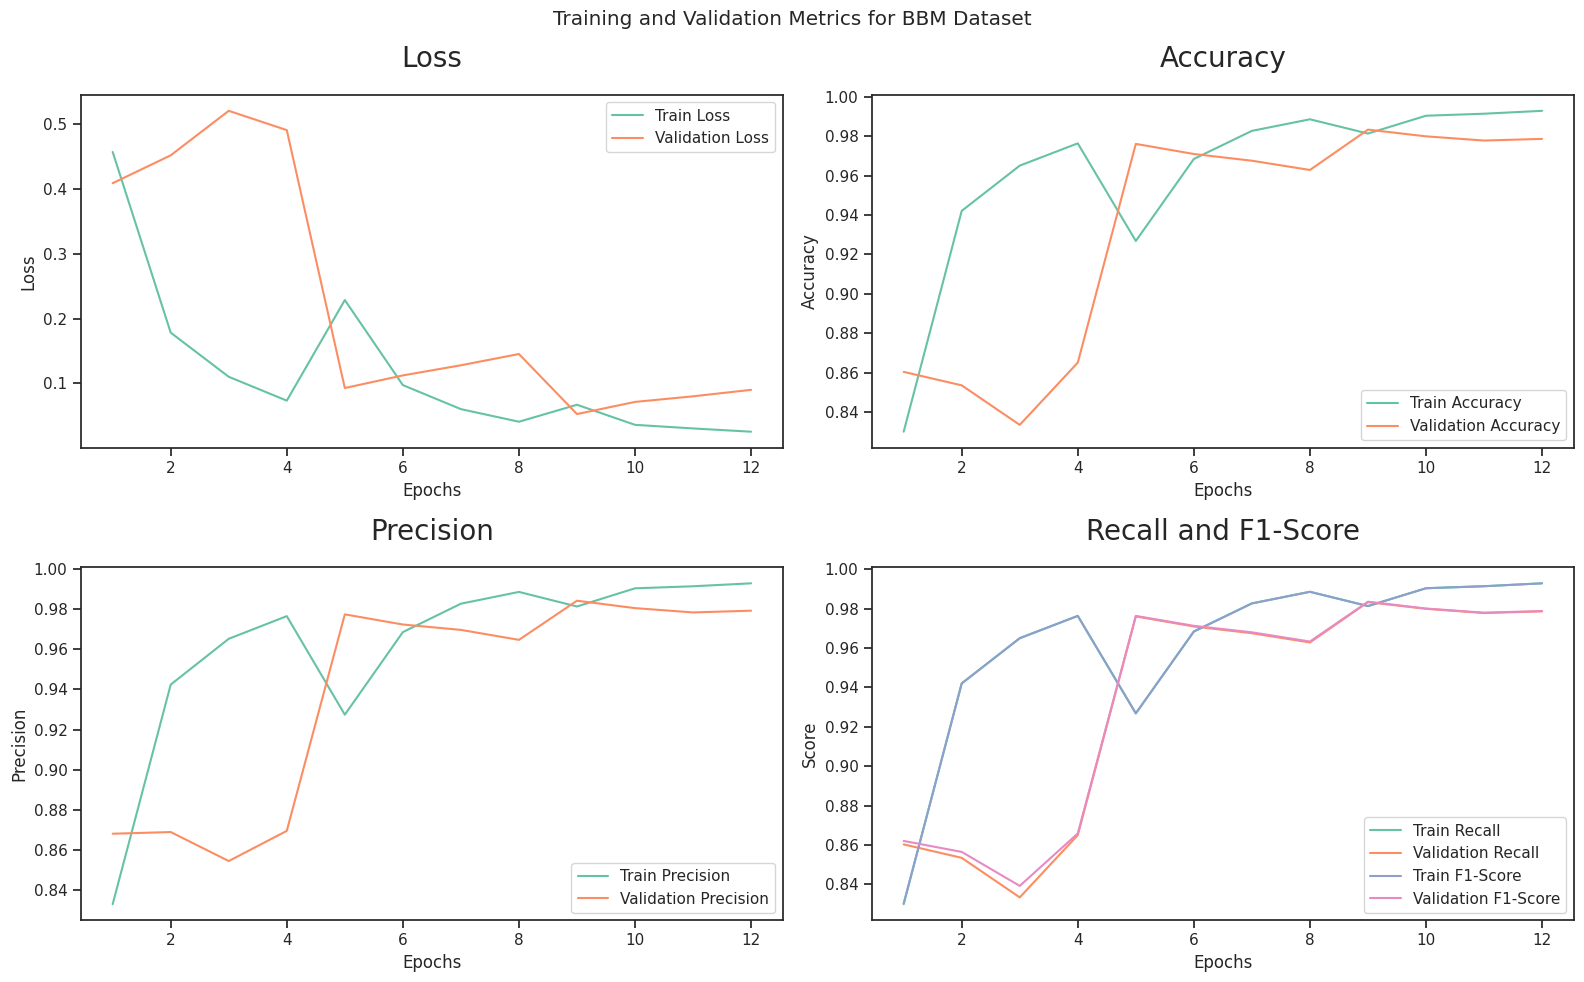

In [26]:
# Plot the history for both datasets
# plot_history(history_pemilu, "Training and Validation Metrics for Pemilu Dataset"),
plot_history(history_bbm, "Training and Validation Metrics for BBM Dataset")

# Documentation

https://github.com/indolem/IndoBERTweet

The warning about tokenizers and parallelism is common when using Hugging Face's transformers library. It indicates that the tokenizers library is being used in a context where parallelism may cause issues, especially in multi-threaded environments.

You can suppress this warning by setting the TOKENIZERS_PARALLELISM environment variable to false. This can be done in your code or in your shell environment.